In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

import seaborn as sns
import numpy as np

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import entropy

import graspy as gp
from graspy.plot import heatmap

/home/ronak/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def plot_heatmap(graph, labels, title):
    cmap = mpl.cm.get_cmap('binary')
#     center = 0
#     vmin = 0
#     vmax = 1
#     norm = mpl.colors.Normalize(0, 1)
#     cc = np.linspace(0.5, 1, 256)
#     cmap = mpl.colors.ListedColormap(cmap(cc))

    heatmap_kws = dict(
        cbar=False,
        font_scale=1.4,
        vmin=0,
        vmax=1,
        inner_hier_labels=labels,
        hier_label_fontsize=20,
        cmap=cmap,
        center=None,
    )
    side_label_kws = dict(labelpad=45, fontsize=24)

    fig, ax = plt.subplots(1, 1, figsize=(20, 16))

    # SBM
    heatmap(graph, ax=ax, **heatmap_kws)
    ax.set_title(title, pad = 100, fontdict = {'fontsize' : 23})

    # Add colorbar
#     sm = plt.cm.ScalarMappable(cmap=cmap)
#     sm.set_array(data)
#     cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
#     cbar.ax.tick_params(labelsize=16)

    plt.savefig(
        "adj_matrix.pdf",
        facecolor="w",
        format="pdf",
        bbox_inches="tight",
    )

    plt.tight_layout()
    plt.show()

In [3]:
graph, labels = gp.datasets.load_drosophila_right(return_labels=True)

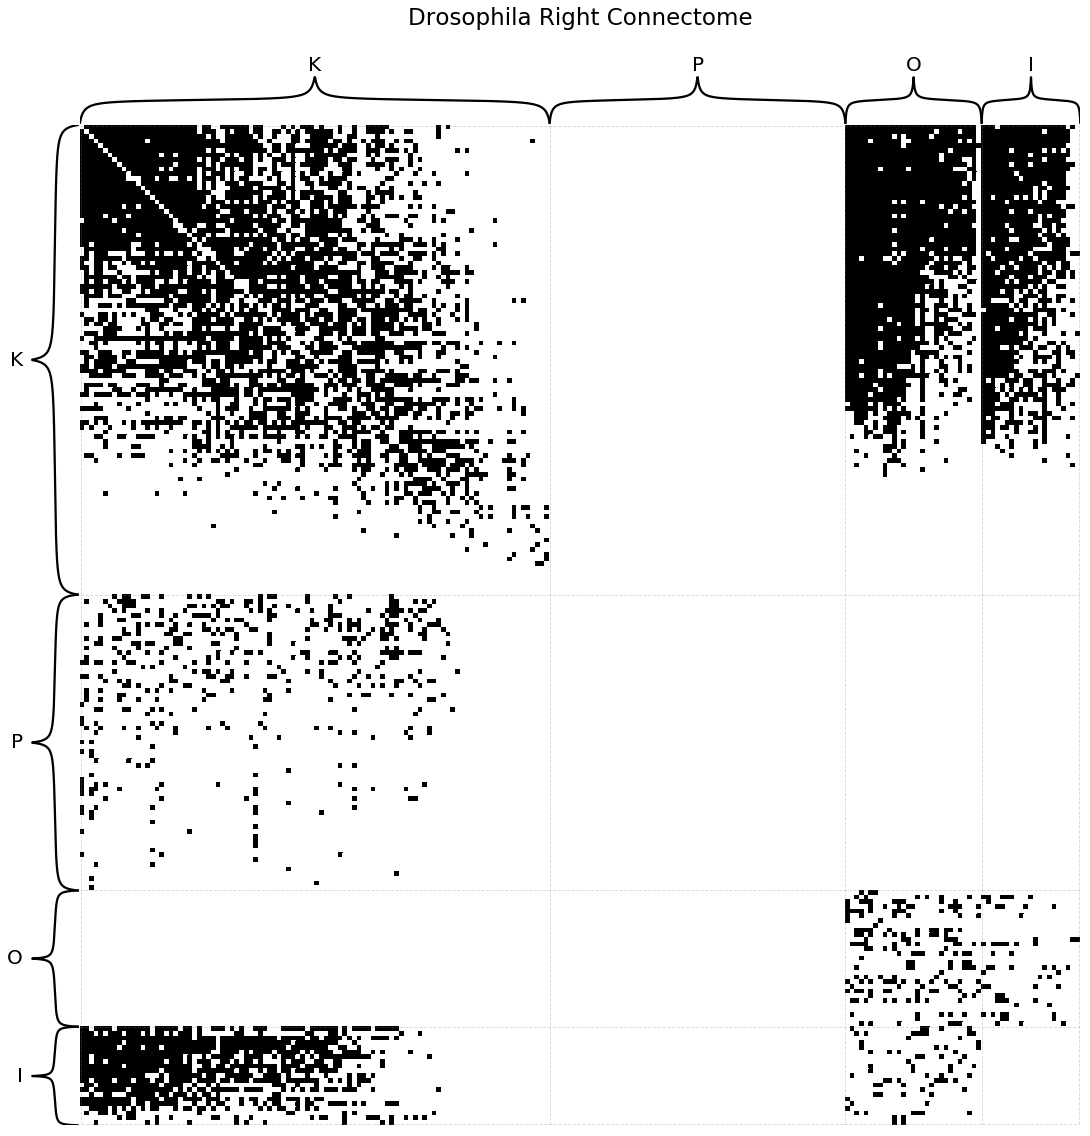

In [4]:
plot_heatmap(graph, labels, "Drosophila Right Connectome")

In [5]:
# Neuronal features and label.
data = pd.read_csv("vdf.csv")
print(data)

                                                     v type  claw  \
0     Thermo KC A_Right - Mushroom Body  Left #4229950   KC   2.0   
1                                        KC12 #4230061   KC   1.0   
2                                        KC10 #4227304   KC   1.0   
3                                        KC42 #8066542   KC   1.0   
4                                        KC16 #4415241   KC   2.0   
5                                      KC100 #11813287   KC   2.0   
6                                LON KC right #8068173   KC   4.0   
7                                        KC21 #5051342   KC   1.0   
8                                         KC2 #3347708   KC   1.0   
9                                        KC13 #4230739   KC   1.0   
10                                       KC90 #9796812   KC   1.0   
11         Thermo KC B_right - mbi2 - unknown #3664102   KC   4.0   
12                                      KC96 #10056280   KC   2.0   
13                                

In [6]:
# Preprocess
labels = data.type.to_list()
unique_labels = np.unique(labels)

data.age = pd.factorize(data.age)[0]
data.v = pd.factorize(data.v)[0]
data = data.fillna(0)
print(data)

       v type  claw         dist  age  cluster
0      0   KC   2.0   337.638010    0        1
1      1   KC   1.0     0.000000    0        1
2      2   KC   1.0  1291.203570    0        1
3      3   KC   1.0   252.633470    0        1
4      4   KC   2.0  1822.295250    0        1
5      5   KC   2.0  1031.646020    0        1
6      6   KC   4.0  3928.179840    0        1
7      7   KC   1.0  5966.114650    0        1
8      8   KC   1.0  7994.829270    0        1
9      9   KC   1.0   946.986460    0        1
10    10   KC   1.0  4249.320010    0        1
11    11   KC   4.0     0.000000    0        1
12    12   KC   2.0  4249.320010    0        1
13    13   KC   1.0  3042.089030    0        1
14    14   KC   2.0  8278.148080    0        1
15    15   KC   1.0  4249.320010    0        1
16    16   KC   2.0  2497.301090    0        1
17    17   KC   1.0  5966.114650    0        1
18    18   KC   1.0  2721.851950    0        1
19    19   KC   1.0  7878.687810    0        1
20    20   KC

In [7]:
col_names = ["claw", "dist", "age", "cluster"]
X = np.array(data[col_names])
y = np.array(pd.factorize(data.type)[0])
print(X.shape)
print(y.shape)

(213, 4)
(213,)


In [8]:
# gp.plot.pairplot(X, labels=labels, col_names = col_names, title = "Drosophila Right Features")
# plt.savefig(
#     "neuron_features.pdf",
#     facecolor="w",
#     format="pdf",
#     bbox_inches="tight",
# )

In [9]:
def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
    
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(), 
                              n_estimators=n_estimators, 
                              max_samples=max_samples, 
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)
    
    cond_entropy = 0
    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
        
        # Randomly split the rest into voting and evaluation.
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        vote_indices = unsampled_indices[:total_unsampled//2]
        eval_indices = unsampled_indices[total_unsampled//2:]
        
        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        est_nodes = tree.apply(X[vote_indices])
        est_classes = y[vote_indices]
        for i in range(len(est_nodes)):
            class_counts[est_nodes[i], est_classes[i]] += 1
        
        row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
        row_sums[row_sums == 0] = 1 # Avoid divide by zero.
        class_probs = class_counts / row_sums[:, None]
        
        # Make the nodes that have no estimation indices uniform.
        # This includes non-leaf nodes, but that will not affect the estimate.
        class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
        
        # Apply finite sample correction and renormalize.
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
        row_sums = class_probs.sum(axis=1)
        class_probs = class_probs / row_sums[:, None]
        
        # Place evaluation points in their corresponding leaf node.
        # Store evaluation posterior in a num_eval-by-num_class matrix.
        eval_class_probs = class_probs[tree.apply(X[eval_indices])]
        # eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
        cond_entropy += np.mean(eval_entropies)
      
    return cond_entropy / n_estimators

def entropy_estimate(y, base = np.exp(1)):
    _, counts = np.unique(y, return_counts=True)
    return entropy(counts, base=base)

In [10]:
def powerset(s):
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1, (1 << x) - 1):
        yield [ss for mask, ss in zip(masks, s) if i & mask]

In [11]:
H_Y = entropy_estimate(y)
H_YX = uf(X, y)
I_XY = H_Y - H_YX
print(H_Y)
print(H_YX)
print(I_XY)

1.2151839186517945
0.29813752861865284
0.9170463900331417


In [12]:
# Compute MI and Conditional MI for each subset of features.
in_features = []
I_YX_in = []
I_YX_out = []

dim_indices = np.arange(X.shape[1])
subsets = powerset(dim_indices)
for in_indices in subsets:
    
    # Generate string names for each subset of features, i.e. s1 = "claw, dist".
    in_list = np.array(col_names)[in_indices]
    in_features.append(','.join(in_list))
    
    out_indices = np.delete(dim_indices, in_indices)
    X_in = X[:, in_indices]
    X_out = X[:, out_indices]
    
    # H(Y | X_in)
    H_YX_in = uf(X_in, y)
    # H_YX_in = np.random.normal()
    
    # I(Y, X_in)
    I_YX_in.append(H_Y - H_YX_in)
    
    # I(Y, X_out | X_in)
    I_YX_out.append(H_YX_in - H_YX)

In [13]:
# Stitch it together in a dataframe.
mi_dict = {
    "in_features" : in_features,
    "I_YX_in" : I_YX_in,
    "I_YX_out|X_in" : I_YX_out,
    "I_XY" : [I_XY]*(2**len(dim_indices) - 2)
}

mi_table = pd.DataFrame(mi_dict)
mi_table.to_csv("mi_table.csv", index = False)
print(mi_table)

          in_features   I_YX_in  I_YX_out|X_in      I_XY
0                claw  0.294528       0.622518  0.917046
1                dist  0.474837       0.442210  0.917046
2           claw,dist  0.485199       0.431848  0.917046
3                 age  0.595321       0.321726  0.917046
4            claw,age  0.589764       0.327282  0.917046
5            dist,age  0.590305       0.326741  0.917046
6       claw,dist,age  0.587259       0.329787  0.917046
7             cluster  0.800531       0.116515  0.917046
8        claw,cluster  0.802666       0.114380  0.917046
9        dist,cluster  0.845698       0.071349  0.917046
10  claw,dist,cluster  0.847468       0.069579  0.917046
11        age,cluster  0.913311       0.003735  0.917046
12   claw,age,cluster  0.917132      -0.000086  0.917046
13   dist,age,cluster  0.914605       0.002442  0.917046
